In [1]:
import torch
import torch.nn as nn
import seaborn as sns
import numpy as np
import os, random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import time
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print("GPU")
else:
  device = torch.device('cpu:0')
  print("CPU")

GPU


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


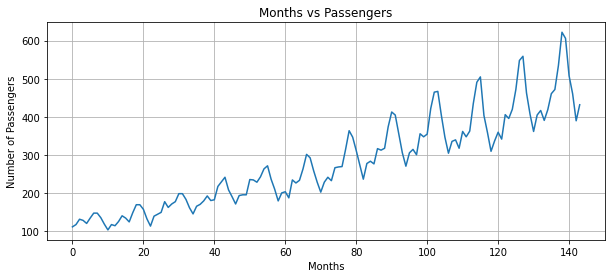

In [2]:
start = time.time()
flights = sns.load_dataset("flights")

plt.figure(figsize=(10,4))
plt.xlabel('Months')
plt.ylabel('Number of Passengers')
plt.title('Months vs Passengers')
plt.grid(True)
plt.plot(flights['passengers'])
plt.show()


all_data = flights['passengers'].astype('float').values

test_data_size = 12
train = all_data[:-test_data_size]
test = all_data[-test_data_size:]

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(train.reshape(-1,1))
train_norm = scaler.transform(train.reshape(-1, 1))
train_norm = torch.FloatTensor(train_norm).view(-1)


window_size = 12

output_size = 6
def create_windows_labels(data, window, output_size):
    input_seq = []
    L = len(data)
    for i in range(L-window-output_size+1):
        seq = data[i:i+window]
        label = data[i+window:i+window+output_size]
        input_seq.append((seq, label))
    return input_seq

train_seq = create_windows_labels(train_norm, window_size, output_size)

In [3]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=output_size):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size, bidirectional=True)

        self.linear = nn.Linear(hidden_layer_size*2, output_size)

        self.hidden_cell = (torch.zeros(2, 1, self.hidden_layer_size).to(device),
                            torch.zeros(2 ,1, self.hidden_layer_size).to(device))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [4]:
model = LSTM().to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0075)
print(model)


epochs = 300

for i in range(epochs):
    for seq, labels in train_seq:
        seq = seq.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(2, 1, model.hidden_layer_size).to(device),
                             torch.zeros(2, 1, model.hidden_layer_size).to(device))
        y_pred = model(seq)

        loss = loss_function(y_pred, labels)
        loss.backward()
        optimizer.step()

    if i%25 == 0:
        print(f'epoch: {i:3} loss: {loss.item():10.8f}')

print(f'epoch: {i:3} loss: {loss.item():10.10f}')



LSTM(
  (lstm): LSTM(1, 100, bidirectional=True)
  (linear): Linear(in_features=200, out_features=6, bias=True)
)
epoch:   0 loss: 0.14981173
epoch:  25 loss: 0.06372556
epoch:  50 loss: 0.04761748
epoch:  75 loss: 0.12794286
epoch: 100 loss: 0.00135174
epoch: 125 loss: 0.00482711
epoch: 150 loss: 0.01351097
epoch: 175 loss: 0.00245636
epoch: 200 loss: 0.00038906
epoch: 225 loss: 0.00405285
epoch: 250 loss: 0.00451204
epoch: 275 loss: 0.00357382
epoch: 299 loss: 0.0258207284


[[415.76922314]
 [433.32940841]
 [439.11514559]
 [417.5404174 ]
 [456.63320655]
 [527.02676946]
 [648.65562344]
 [582.86108935]
 [523.34964821]
 [415.22438684]
 [404.0148236 ]
 [444.77903889]
 [459.44572502]
 [495.61681011]
 [572.90722126]
 [506.31884077]
 [501.15077773]
 [493.51439112]
 [444.05504712]
 [473.37034383]
 [529.31738847]
 [458.08803791]
 [479.36818743]
 [575.17923588]
 [716.82487601]
 [599.28177559]
 [526.99514741]
 [376.62272261]
 [424.2940172 ]
 [547.13074678]
 [723.79089409]
 [625.48541898]
 [596.03953892]
 [401.21423119]
 [492.03010732]
 [468.377314  ]]


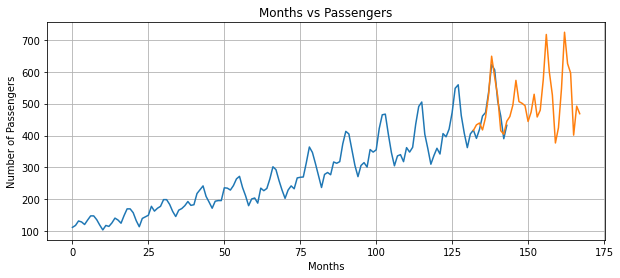

Time to run the code: 109.5132064819336 sec


In [5]:
fut_pred = 36
test_inputs = train_norm[-12:].tolist()


for i in range(fut_pred//output_size):
    seq = torch.FloatTensor(test_inputs[-window_size:])
    seq = seq.to(device)
    with torch.no_grad():
        model.hidden_cell = (torch.zeros(2, 1, model.hidden_layer_size).to(device),
                             torch.zeros(2, 1, model.hidden_layer_size).to(device))
        test_inputs += model(seq).cpu().data.numpy().tolist()


actual_predictions = scaler.inverse_transform(np.array(test_inputs[window_size:] ).reshape(-1, 1))
print(actual_predictions)


plt.figure(figsize=(10,4))
plt.xlabel('Months')
plt.ylabel('Number of Passengers')
plt.title('Months vs Passengers')
plt.grid(True)
plt.plot(flights['passengers'])
plt.plot(np.arange(132, 168), actual_predictions)
plt.show()

end = time.time()

print("Time to run the code: " + str(end-start) + " sec")